In [37]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read, mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment_loop, Dial
import pandas as pd
import os
import pathlib
import string
import datetime

In [38]:
# defining file
year = '1993'
start_day = '1'
end_day = '365'
Output_Plots = False

In [39]:
# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [40]:
print(np.linspace(0, 24, num=25).shape)
print(np.linspace(0, 24, num=25))

(25,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]


In [41]:
# define initial params
statistics_thresh=100 # Don't calculate stats if less microbursts in the bin.
percentiles = np.array([25, 50, 75])
MLT_bins = np.linspace(0, 24, num=24+1)
L_bins = np.linspace(3, 8, num=10+1)
L_labels = [2,4,6]

# Create empty microburst histogram
H_LvMLT_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, L_bins])
H_isoavgs_MB = np.nan*np.zeros((len(MLT_bins), len(L_bins), len(percentiles)))
H_LvMLT_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, L_bins])
H_isoavgs_BG = np.nan*np.zeros((len(MLT_bins), len(L_bins), len(percentiles)))

# Create empty parameter lists
MLT_list_MB = np.array([])
LS_list_MB = np.array([])
iso_list_MB = np.array([])
MLT_list_BG = np.array([])
LS_list_BG = np.array([])
iso_list_BG = np.array([])

for day_of_year in np.arange(int(start_day), int(end_day)+1):
    # name the day
    if len(str(day_of_year)) == 1:
        file = 'hhrr' + year + '00' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 2:
        file = 'hhrr' + year + '0' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 3:
        file = 'hhrr' + year + str(day_of_year) + '.txt'

    # reading in electron counts files:
    t_electrons, r1, r2, r3, r4 = read(year + '_data\\' + file)

    # reading in orbit/attitude data file
    OrbAtt_mask = []
    for i in np.arange(len(OrbAtt_names)):
        OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
    OA_file = OrbAtt_names[OrbAtt_mask][0]
    
    directory = 'E:\SAMPEX_Data\\' + year + '_data\\'
    OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
    # Augment OrbAtt data to fit counts data
    t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)

    
    
    
    
    
    ############## mask for spatial/temporal regions ##############
    
    mask = np.abs(90 - P_OrbAtt) >= 50
    t_OrbAtt = t_OrbAtt[mask]; LS_OrbAtt = LS_OrbAtt[mask]; MLT_OrbAtt = MLT_OrbAtt[mask];
    P_OrbAtt = P_OrbAtt[mask]; Lat_OrbAtt = Lat_OrbAtt[mask]; Long_OrbAtt = Long_OrbAtt[mask];
    R_OrbAtt = R_OrbAtt[mask]; t_electrons = t_electrons[mask]; r1 = r1[mask]; r2 = r2[mask]; r3 = r3[mask]; r4 = r4[mask]

    ###############################################################
       
    
    
    
    
    
    # find microburst times and N_100, SSD1, SSD4 counts using algorithm
    t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)

    # create background counts mask
    BG_mask = ~MB_mask

    # calculation of the isotropy indices of electron counts
    iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
    iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

    # create the MB dial params
    if np.sum(MB_mask) > 0:
        t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
        P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
        R_OrbAtt_mb = R_OrbAtt[mb_index]
      
        # Add histogram for day # to cumulative histograms
        H_LvMLT_MB_day, _, _ = np.histogram2d(MLT_OrbAtt_mb, LS_OrbAtt_mb, bins=[MLT_bins, L_bins])
        H_LvMLT_MB += H_LvMLT_MB_day
        
        # Add parameters to lists
        MLT_list_MB = np.append(MLT_list_MB, MLT_OrbAtt_mb)
        LS_list_MB = np.append(LS_list_MB, LS_OrbAtt_mb)
        iso_list_MB = np.append(iso_list_MB, iso_indices_MB)
        
    # create the BG dial params
    if np.sum(BG_mask) > 0:
        t_OrbAtt_bg = t_OrbAtt[BG_mask]; LS_OrbAtt_bg = LS_OrbAtt[BG_mask]; MLT_OrbAtt_bg = MLT_OrbAtt[BG_mask];
        P_OrbAtt_bg = P_OrbAtt[BG_mask]; Lat_OrbAtt_bg = Lat_OrbAtt[BG_mask]; Long_OrbAtt_bg = Long_OrbAtt[BG_mask];
        R_OrbAtt_bg = R_OrbAtt[BG_mask]
        
        # Add histogram for day # to cumulative histograms
        H_LvMLT_BG_day, _, _ = np.histogram2d(MLT_OrbAtt_bg, LS_OrbAtt_bg, bins=[MLT_bins, L_bins])
        H_LvMLT_BG += H_LvMLT_BG_day
        
        # Add parameters to lists
        MLT_list_BG = np.append(MLT_list_BG, MLT_OrbAtt_bg)
        LS_list_BG = np.append(LS_list_BG, LS_OrbAtt_bg)
        iso_list_BG = np.append(iso_list_BG, iso_indices_BG)

In [42]:
print(H_LvMLT_MB.shape)
print(np.nanmax(H_LvMLT_MB))
print(np.nanmin(H_LvMLT_MB))

print(H_LvMLT_BG.shape)
print(np.nanmax(H_LvMLT_BG))
print(np.nanmin(H_LvMLT_BG))

(24, 10)
1905.0
0.0
(24, 10)
523211.0
68219.0


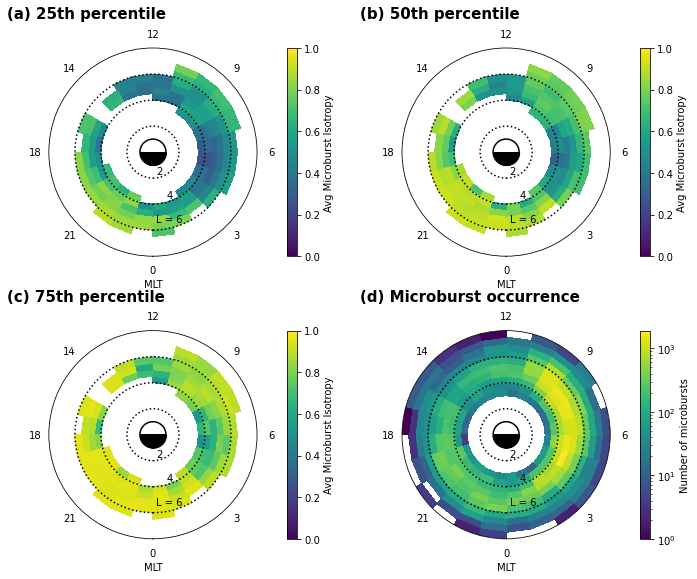

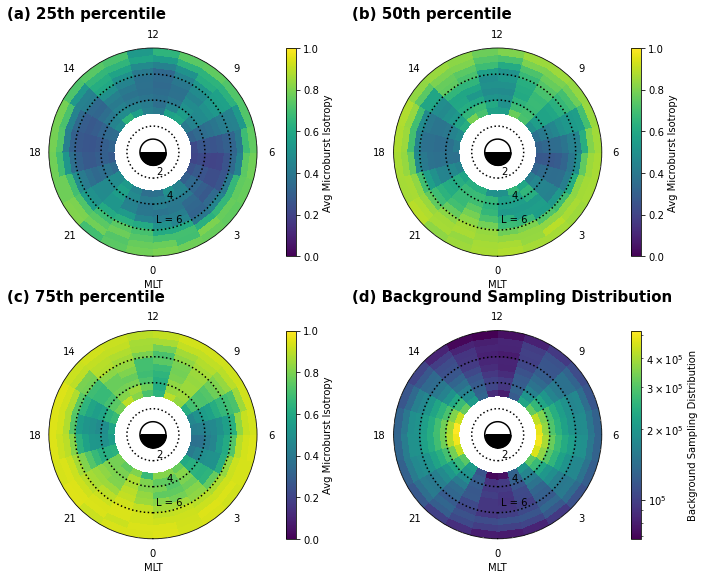

In [46]:
# create MB iso vs MLT/LShell dial plot
# choose colorbar
cmap = 'viridis'

# create empty histogram
H_isoavgs_MB = np.nan*np.zeros((len(MLT_bins), len(L_bins), len(percentiles)))

# populate histogram
for i, (start_MLT, end_MLT) in enumerate(zip(MLT_bins[:-1], MLT_bins[1:])):
    for j, (start_L, end_L) in enumerate(zip(L_bins[:-1], L_bins[1:])):
        
        iso_values = iso_list_MB[(MLT_list_MB > start_MLT) & (MLT_list_MB < end_MLT) & (LS_list_MB > start_L) & \
                                 (LS_list_MB < end_L)]

        if iso_values.shape[0] >= statistics_thresh:
            H_isoavgs_MB[i, j, :] = np.nanpercentile(iso_values, percentiles)

# plot histograms
fig = plt.figure(figsize=(10, 8))
ax = [plt.subplot(2, 2, i, projection='polar') for i in range(1, 5)]

for i, ax_i in enumerate(ax[:-1]):
    d = Dial(ax_i, MLT_bins, L_bins, H_isoavgs_MB[:, :, i])
    d.draw_dial(L_labels=L_labels,
            mesh_kwargs={'cmap':cmap, 'vmin': 0, 'vmax': 1},
            colorbar_kwargs={'label':f'Avg Microburst Isotropy', 'pad':0.1})
    annotate_str = f'({string.ascii_lowercase[i]}) {percentiles[i]}th percentile'
    ax_i.text(-0.2, 1.2, annotate_str, va='top', transform=ax_i.transAxes, 
            weight='bold', fontsize=15)

# choose colorbar
cmap = 'viridis'

# plot MB occurance histogram
d4 = Dial(ax[-1], MLT_bins, L_bins, H_LvMLT_MB)
d4.draw_dial(L_labels=L_labels,
            mesh_kwargs={'norm':matplotlib.colors.LogNorm(), 'cmap':cmap},
            colorbar_kwargs={'label':'Number of microbursts', 'pad':0.1})
annotate_str = f'({string.ascii_lowercase[len(ax)-1]}) Microburst occurrence'
ax[-1].text(-0.2, 1.2, annotate_str, va='top', transform=ax[-1].transAxes, 
            weight='bold', fontsize=15)

for ax_i, label_i in zip(ax, string.ascii_lowercase):
    annotate_str = f'({label_i})'
    ax_i.text(0, 1, annotate_str, va='top', color='white', weight='bold', 
                transform=ax_i.transAxes, fontsize=20)
plt.tight_layout()
plt.show()

# create BG iso vs MLT/LShell dial plot
# choose colorbar
cmap = 'viridis'

# create empty histogram
H_isoavgs_BG = np.nan*np.zeros((len(MLT_bins), len(L_bins), len(percentiles)))

# populate histogram
for i, (start_MLT, end_MLT) in enumerate(zip(MLT_bins[:-1], MLT_bins[1:])):
    for j, (start_L, end_L) in enumerate(zip(L_bins[:-1], L_bins[1:])):
        
        iso_values = iso_list_BG[(MLT_list_BG > start_MLT) & (MLT_list_BG < end_MLT) & (LS_list_BG > start_L) & \
                                 (LS_list_BG < end_L)]

        if iso_values.shape[0] >= statistics_thresh:
            H_isoavgs_BG[i, j, :] = np.nanpercentile(iso_values, percentiles)

# plot histograms
fig = plt.figure(figsize=(10, 8))
ax = [plt.subplot(2, 2, i, projection='polar') for i in range(1, 5)]

for i, ax_i in enumerate(ax[:-1]):
    d = Dial(ax_i, MLT_bins, L_bins, H_isoavgs_BG[:, :, i])
    d.draw_dial(L_labels=L_labels,
            mesh_kwargs={'cmap':cmap, 'vmin': 0, 'vmax': 1},
            colorbar_kwargs={'label':f'Avg Microburst Isotropy', 'pad':0.1})
    annotate_str = f'({string.ascii_lowercase[i]}) {percentiles[i]}th percentile'
    ax_i.text(-0.2, 1.2, annotate_str, va='top', transform=ax_i.transAxes, 
            weight='bold', fontsize=15)

# choose colorbar
cmap = 'viridis'

# plot BG sampling distribution histogram
d4 = Dial(ax[-1], MLT_bins, L_bins, H_LvMLT_BG)
d4.draw_dial(L_labels=L_labels,
            mesh_kwargs={'norm':matplotlib.colors.LogNorm(), 'cmap':cmap},
            colorbar_kwargs={'label':'Background Sampling Distribution', 'pad':0.1})
annotate_str = f'({string.ascii_lowercase[len(ax)-1]}) Background Sampling Distribution'
ax[-1].text(-0.2, 1.2, annotate_str, va='top', transform=ax[-1].transAxes, 
            weight='bold', fontsize=15)

for ax_i, label_i in zip(ax, string.ascii_lowercase):
    annotate_str = f'({label_i})'
    ax_i.text(0, 1, annotate_str, va='top', color='white', weight='bold', 
                transform=ax_i.transAxes, fontsize=20)
plt.tight_layout()
plt.show()

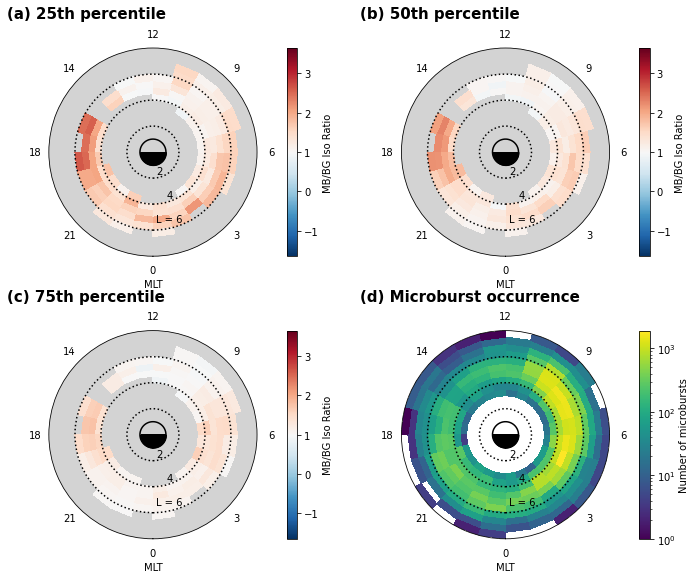

In [44]:
# choose colorbar
cmap = 'RdBu_r'

# create ratio histogram
H_isoavgs_ratio = H_isoavgs_MB/H_isoavgs_BG

# plot difference dial
fig = plt.figure(figsize=(10, 8))
ax = [plt.subplot(2, 2, i, projection='polar') for i in range(1, 5)]

for i, ax_i in enumerate(ax[:-1]):
    d = Dial(ax_i, MLT_bins, L_bins, H_isoavgs_ratio[:, :, i])
    ax_i.set_facecolor('lightgrey') ## EDIT ##
    d.draw_dial(L_labels=L_labels,
            mesh_kwargs={'cmap':cmap, 'vmin': 1-np.nanmax(H_isoavgs_ratio), 'vmax': 1+np.nanmax(H_isoavgs_ratio)},
            colorbar_kwargs={'label':f'MB/BG Iso Ratio', 'pad':0.1})
    annotate_str = f'({string.ascii_lowercase[i]}) {percentiles[i]}th percentile'
    ax_i.text(-0.2, 1.2, annotate_str, va='top', transform=ax_i.transAxes, 
            weight='bold', fontsize=15)
    
# choose colorbar
cmap = 'viridis'
    
d4 = Dial(ax[-1], MLT_bins, L_bins, H_LvMLT_MB)
d4.draw_dial(L_labels=L_labels,
            mesh_kwargs={'norm':matplotlib.colors.LogNorm(), 'cmap':cmap},
            colorbar_kwargs={'label':'Number of microbursts', 'pad':0.1})
annotate_str = f'({string.ascii_lowercase[len(ax)-1]}) Microburst occurrence'
ax[-1].text(-0.2, 1.2, annotate_str, va='top', transform=ax[-1].transAxes, 
            weight='bold', fontsize=15)

for ax_i, label_i in zip(ax, string.ascii_lowercase):
    annotate_str = f'({label_i})'
    ax_i.text(0, 1, annotate_str, va='top', color='white', weight='bold', 
                transform=ax_i.transAxes, fontsize=20)
plt.tight_layout()
plt.show()

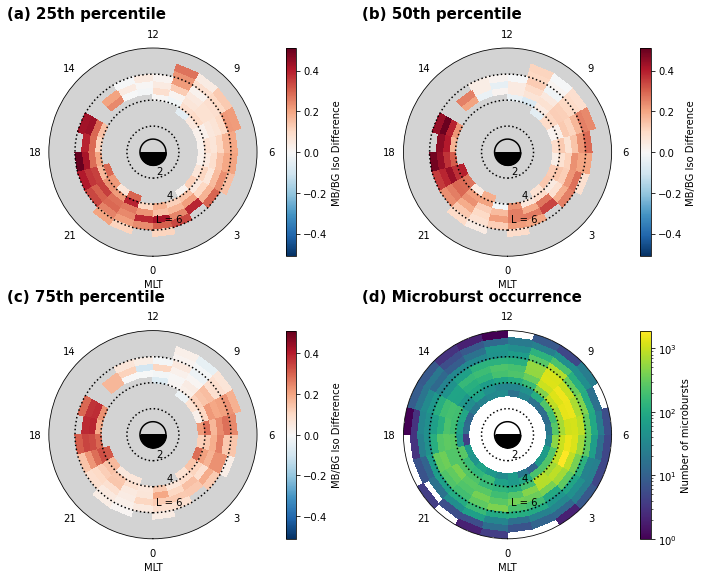

In [45]:
# choose colorbar
cmap = 'RdBu_r'

# create difference histogram
H_isoavgs_diff = H_isoavgs_MB - H_isoavgs_BG

# plot difference dial
fig = plt.figure(figsize=(10, 8))
ax = [plt.subplot(2, 2, i, projection='polar') for i in range(1, 5)]

for i, ax_i in enumerate(ax[:-1]):
    d = Dial(ax_i, MLT_bins, L_bins, H_isoavgs_diff[:, :, i])
    ax_i.set_facecolor('lightgrey') ## EDIT ##
    d.draw_dial(L_labels=L_labels,
            mesh_kwargs={'cmap':cmap, 'vmin': -np.nanmax(H_isoavgs_diff), 'vmax': np.nanmax(H_isoavgs_diff)},
            colorbar_kwargs={'label':f'MB/BG Iso Difference', 'pad':0.1})
    annotate_str = f'({string.ascii_lowercase[i]}) {percentiles[i]}th percentile'
    ax_i.text(-0.2, 1.2, annotate_str, va='top', transform=ax_i.transAxes, 
            weight='bold', fontsize=15)
    
# choose colorbar
cmap = 'viridis'

d4 = Dial(ax[-1], MLT_bins, L_bins, H_LvMLT_MB)
d4.draw_dial(L_labels=L_labels,
            mesh_kwargs={'norm':matplotlib.colors.LogNorm(), 'cmap':cmap},
            colorbar_kwargs={'label':'Number of microbursts', 'pad':0.1})
annotate_str = f'({string.ascii_lowercase[len(ax)-1]}) Microburst occurrence'
ax[-1].text(-0.2, 1.2, annotate_str, va='top', transform=ax[-1].transAxes, 
            weight='bold', fontsize=15)

for ax_i, label_i in zip(ax, string.ascii_lowercase):
    annotate_str = f'({label_i})'
    ax_i.text(0, 1, annotate_str, va='top', color='white', weight='bold', 
                transform=ax_i.transAxes, fontsize=20)
plt.tight_layout()
plt.show()